In [1]:
#generic imports
import numpy as np
import time
import matplotlib.pyplot as plt

#ambit stochastics imports
from generate_trawls_with_gaussian_marginal import generate_gaussian_seed_trawls
#gmm fitting of envelope params + gmm / mle for levy seed params
from ambit_stochastics.helpers.marginal_distribution_functions import fit_trawl_marginal
from ambit_stochastics.helpers.acf_functions import fit_trawl_envelope_gmm
import pickle

#jax imports
from jax.config import config
config.update("jax_enable_x64", True)
from bfgs_for_cl_helper import do_modified_bfgs
from   jax import random
import jax.numpy as jnp
import jax

default_precision = jnp.float64
print('Default precision is: ',default_precision)

#trawl simulation parameters
tau = 1
nr_trawls = 150
nr_simulations = 2
TRUE_GAUSSIAN_PARAMS = (-5, 3) #alpha, beta (rate) not alpha, theta (scale). trawl simulation uses alpha, scale, so need to pass 5, 1/2 there
assert TRUE_GAUSSIAN_PARAMS[1] > 0
envelope = 'gamma'
jax_seed = 4564340345993
key = random.PRNGKey(jax_seed)

#trawl function parameters
TRUE_ENVELOPE_PARAMS = (1.5,0.75)
np.random.seed(seed = 36363)

np_random_seeds = np.random.randint(low = 1, high = 2**31, size = 1)
    

trawl_instance =  generate_gaussian_seed_trawls(tau = tau,nr_simulations = nr_simulations,
                      nr_trawls = nr_trawls, envelope = envelope,envelope_params = TRUE_ENVELOPE_PARAMS,
                      gaussian_part_params = TRUE_GAUSSIAN_PARAMS,np_seed = np_random_seeds[0])  

2023-06-21 16:48:07.351597: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-21 16:48:07.412896: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-21 16:48:07.415902: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Default precision is in jax_aux file is:  <class 'jax.numpy.float64'>


2023-06-21 16:48:08.847354: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Default precision is:  <class 'jax.numpy.float64'>


In [90]:
#np.mean(trawl_instance.values[-1]),(np.mean(trawl_instance.values[-1]**2) - np.mean(trawl_instance.values[-1])**2)**0.5
lags_to_use   = (1,3,5,10)
n_to_use      = 100
values_to_use = trawl_instance.values[0,:n_to_use]  

initial_tensor = jnp.array([-4.5, np.log(3.5),np.log(TRUE_ENVELOPE_PARAMS[0]),np.log(TRUE_ENVELOPE_PARAMS[1])])


nr_samples  =    10**5
max_taylor_deg = 3
nr_batches= 5

from jax_aux_jitted_gaussian import corr_jax,create_joints_jax, sample_z, estimators_likelihood_CV_demo,likelihood_and_grad,likelihood_jacobians
pairs = create_joints_jax(values_to_use,1)
l1,l2 = pairs[:,0], pairs[:,1]
transformed_params_ = initial_tensor.copy()
transformed_params_1_ = initial_tensor.copy()

delta_x = 10**(-4)

In [91]:
#np.save(file =  'values_to_use.npy', arr = values_to_use)

In [92]:
z   = sample_z(transformed_params_1_ = transformed_params_1_, tau_ = tau, l1 = l1, envelope = envelope, nr_samples = nr_samples, key_ = key)
tau_ = tau
result = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_, transformed_params_1_ = transformed_params_1_,
                              pairs = pairs, envelope = envelope, tau =  tau, nr_samples = nr_samples, key = key)

result_dispalced_1 = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_ + delta_x * jnp.array([1,0,0,0]), transformed_params_1_ = transformed_params_1_ + delta_x * jnp.array([1,0,0,0]),
                              pairs = pairs, envelope = envelope, tau =  tau, nr_samples = nr_samples, key = key)

result_dispalced_2 = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_ + delta_x * jnp.array([0,1,0,0]), transformed_params_1_ = transformed_params_1_ + delta_x * jnp.array([0,1,0,0]),
                              pairs = pairs, envelope = envelope, tau =  tau, nr_samples = nr_samples, key = key)

result_dispalced_3 = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_ + delta_x * jnp.array([0,0,1,0]), transformed_params_1_ = transformed_params_1_ + delta_x * jnp.array([0,0,1,0]),
                              pairs = pairs, envelope = envelope, tau =  tau, nr_samples = nr_samples, key = key)

result_dispalced_4 = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_ + delta_x * jnp.array([0,0,0,1]), transformed_params_1_ = transformed_params_1_ + delta_x * jnp.array([0,0,0,1]),
                              pairs = pairs, envelope = envelope, tau =  tau, nr_samples = nr_samples, key = key)

In [93]:
l_and_grad = likelihood_and_grad(transformed_theta = transformed_params_, transformed_theta_1 = transformed_params_1_,
                    pairs = pairs, envelope = envelope, tau = tau , nr_mc_samples_per_batch = nr_samples, nr_batches =nr_batches , 
                    max_taylor_deg = max_taylor_deg, key = key)
l_and_grad_2 = likelihood_jacobians(transformed_params_,  transformed_params_1_,   pairs , envelope , tau , nr_samples , key )

In [124]:
jacobians_f, jacobians_z = l_and_grad_2
nabla_theta_f, pg_f = jacobians_f  
zero_variable, pg_z = jacobians_z
#print(pg_f.shape)
#print(pg_f.mean(axis=1))
to_use = 3

results_dispacled = [result_dispalced_1,result_dispalced_2,result_dispalced_3,result_dispalced_4]
finite_diff_approx = (results_dispacled[to_use-1][0].mean(axis=1) - result[0].mean(axis=1))/delta_x
ad = (nabla_theta_f + pg_f).mean(axis=1)[:,to_use-1]
correction_chain_rule = np.array([1, 3.5,TRUE_ENVELOPE_PARAMS[0],TRUE_ENVELOPE_PARAMS[1]])


In [125]:
np.abs(100 *(ad - finite_diff_approx) / ad),np.abs(100 * (r_all[to_use] *np.exp(r_all[0]) -finite_diff_approx / correction_chain_rule[to_use-1] ) / (r_all[to_use] * np.exp(r_all[0])))

(array([5.44515597e-02, 1.18761992e-02, 5.70211358e-03, 1.00655533e-02,
        4.28966260e-02, 5.83918914e-03, 6.72167047e-03, 6.68911504e-03,
        1.13721757e-04, 3.47786719e-03, 6.16524753e-03, 9.11628238e-03,
        1.97115292e-02, 8.39981386e-03, 8.95585038e-03, 5.57811298e-03,
        3.90718966e-03, 3.99309777e-03, 3.37423560e-03, 4.01431175e-04,
        4.99696737e-04, 9.09925300e-03, 9.39588889e-03, 8.94291919e-03,
        8.62521654e-01, 6.25884511e-03, 7.88264103e-03, 6.62380039e-03,
        8.46215344e-04, 1.20748832e-03, 7.38502002e-03, 1.02131017e-02,
        6.36274914e-03, 1.98490378e-02, 1.35169641e-03, 4.39922973e-03,
        5.96973358e-03, 6.51906021e-03, 3.20080256e-03, 4.01317065e-03,
        2.80472073e-03, 3.03029118e-03, 3.93177623e-03, 5.43886297e-03,
        7.88021672e-03, 7.36552509e-03, 6.17181968e-03, 5.64144563e-02,
        5.23583233e-04, 2.89362060e-03, 3.65334421e-03, 5.55769604e-03,
        1.49942961e-03, 3.29012350e-03, 3.66411530e-03, 1.003516

In [ ]:
#np.median(np.abs((pg_f.mean(axis=1) - l_and_grad[2])/ l_and_grad[2]),axis=0)
# THIS IS OK np.median(100*np.abs((nabla_theta_f.mean(axis=1) - (l_and_grad[1] -l_and_grad[2] ))/ nabla_theta_f.mean(axis=1)),axis=0)

In [97]:
#zzzzzz = np.log(result[0].mean(axis=1))
#print(np.sum(zzzzzz),'\n')
#print(zzzzzz)

#print(result[0].mean(axis=1))
r_all = np.load('r_all.npy')
#r_all.shape #likelihood and then grads
#100 *(r_all[0] - np.log(l_and_grad[0])) / r_all[0]#likelihood looks good

In [46]:

pdv_log_likelihood = np.array([l_and_grad[1][:,i]/ (l_and_grad[0] * correction_chain_rule[i] ) for i in range(4)])
pdv_log_likelihood_percentage_errors = [100*np.abs(pdv_log_likelihood[i] - r_all[i+1])/np.abs(r_all[i+1])  for i in range(4)]
np.median(pdv_log_likelihood_percentage_errors,axis=1)

#pdv_log_likelihood = np.array([l_and_grad[2][:,i]/ (l_and_grad[0] * correction_chain_rule[i] ) for i in range(4)])
#pdv_log_likelihood_percentage_errors = [100*np.abs(pdv_log_likelihood[i] - r_all[i+1])/np.abs(r_all[i+1])  for i in range(4)]


array([ 3.90382165,  0.04305877, 14.84612883, 14.8462256 ])

In [17]:
pdv_log_likelihood_pg_f = np.array([np.mean(pg_f +nabla_theta_f,axis=1)[:,i]/ (l_and_grad[0] * correction_chain_rule[i] ) for i in range(4)])
pdv_log_likelihood_percentage_errors_pg_f = [100*np.abs(r_all[i] - pdv_log_likelihood_pg_f[i])/np.abs(r_all[i])  for i in range(4)]

np.median(pdv_log_likelihood_percentage_errors_pg_f,axis=1)

array([ 98.55031361, 218.85470694,  88.66853484, 234.82629126])

In [18]:
[100*np.abs(pdv_log_likelihood_2[i] - r_all[i+1])/np.abs(r_all[i+1])  for i in range(4)]


NameError: name 'pdv_log_likelihood_2' is not defined

[3.903821648117885, 0.04305876692733996, 14.846128833203402, 14.846225604950085]


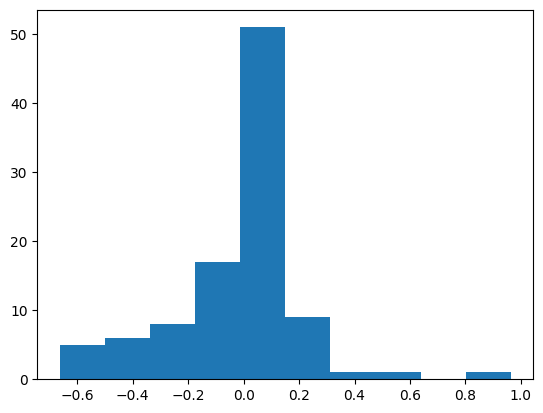

In [19]:
import matplotlib.pyplot as plt
print([np.median(pdv_log_likelihood_percentage_errors[i]) for i in range(4)])
_ = plt.hist(pdv_log_likelihood[3])


In [ ]:
pdv_log_likelihood[3][24],r_all[3+1][24]

In [ ]:
grad_differences = [100 * (l_and_grad[1][:,i] - r_all[i+1])/r_all[i+1] for i in range(4)]

In [ ]:
[np.median(i) for i in grad_differences]

In [ ]:
import matplotlib.pyplot as plt
_= plt.hist(grad_differences[1],bins = 150)

In [27]:
all_values

NameError: name 'all_values' is not defined

In [79]:
from jax_aux_jitted_gaussian import minus_lambda_function_for_cl_and_grad_at_lags



minus_lambda_func_2 = minus_lambda_function_for_cl_and_grad_at_lags(values_to_use, envelope, \
                                        tau , nr_samples, nr_batches, 
                                        2, key, lags_to_use)

minus_lambda_func_3 = minus_lambda_function_for_cl_and_grad_at_lags(values_to_use, envelope, \
                                        tau , nr_samples, nr_batches, 
                                        3, key, lags_to_use)
minus_lambda_func_4 = minus_lambda_function_for_cl_and_grad_at_lags(values_to_use, envelope, \
                                        tau , nr_samples, nr_batches, 
                                        4, key, lags_to_use)

In [80]:
minus_lambda_func_2(transformed_params_)

(Array(4.9870489, dtype=float64),
 Array([ 0.16744527,  0.63081933, -0.00188695,  0.00127258], dtype=float64))

In [81]:
minus_lambda_func_3(transformed_params_)

(Array(nan, dtype=float64),
 Array([-0.01862151,  0.72388627, -0.1959936 ,  0.1321806 ], dtype=float64))

In [82]:
minus_lambda_func_4(transformed_params_)

(Array(4.98708576, dtype=float64),
 Array([ 0.05777528,  0.63089838, -0.02500646,  0.01686468], dtype=float64))

In [83]:
lag_ = 3 #!!!!!!!
pairs_at_lag_3 = create_joints_jax(values_to_use,lag_)
likelihood, _ = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_.copy(), transformed_params_1_ = transformed_params_.copy(), pairs = pairs_at_lag_3, envelope = envelope,
                                tau = tau * lag_, nr_samples = nr_samples, key = key) #subkey not key here
jacobians_f, jacobians_z = likelihood_jacobians(transformed_params_.copy(), transformed_params_1_.copy(), pairs_at_lag_3, envelope, tau * lag_, nr_samples, key)
nabla_theta_f, pg_f = jacobians_f  
-np.mean(np.log(likelihood.mean(axis=1)),axis=0)

5.033068282897426

In [84]:
likelihood2, _ = estimators_likelihood_CV_demo(transformed_params_ = transformed_params_.copy(), transformed_params_1_ = transformed_params_.copy(), pairs = pairs_at_lag_3, envelope = envelope,
                                tau = tau * lag_, nr_samples = nr_samples, key = random.split(key)[1]) #subkey not key here
np.log(likelihood2.mean(axis=1)).mean(axis=0)

-5.033430586947184

In [85]:
-np.mean((nabla_theta_f + pg_f).mean(axis=1) / likelihood.mean(axis=1,keepdims=True),axis=0)

Array([ 0.07749922,  0.61267187, -0.01913413,  0.00951096], dtype=float64)

In [87]:
minus_lambda_func_3 = minus_lambda_function_for_cl_and_grad_at_lags(values_to_use, envelope, \
                                        tau , nr_samples, nr_batches, 
                                        3, key, (lag_,))

minus_lambda_func_3(transformed_params_.copy())

(Array(5.0179901, dtype=float64),
 Array([ 0.05236269,  0.60046246, -0.01254031,  0.00623339], dtype=float64))

In [88]:
minus_lambda_func_2 = minus_lambda_function_for_cl_and_grad_at_lags(values_to_use, envelope, \
                                        tau , nr_samples, nr_batches, 
                                        2, key, (lag_,))

minus_lambda_func_2(transformed_params_.copy())

(Array(5.03313463, dtype=float64),
 Array([ 0.07339798,  0.61249286, -0.07719407,  0.0383707 ], dtype=float64))